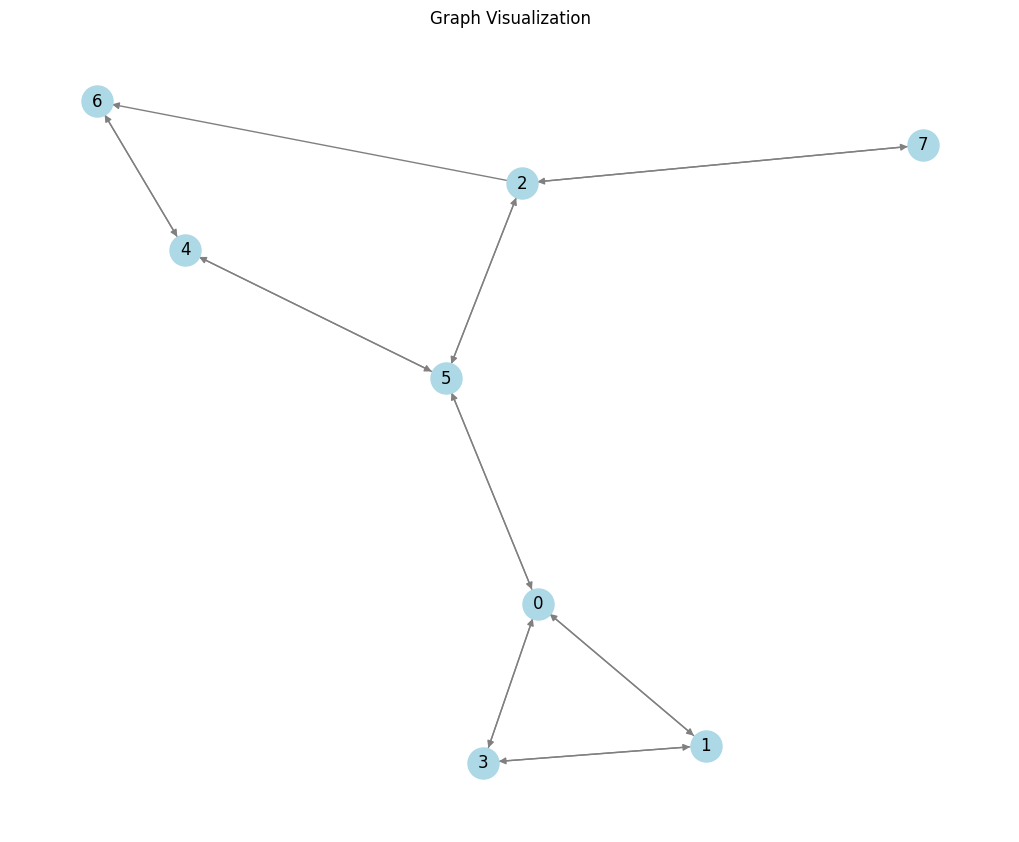

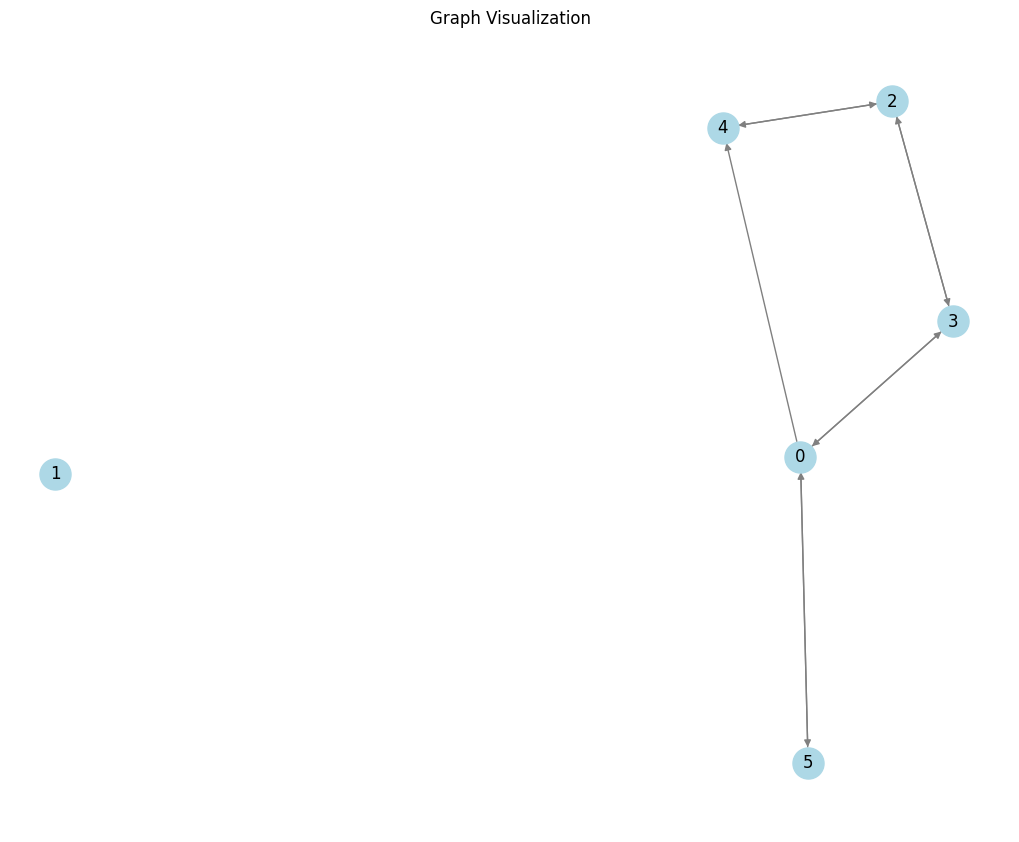

In [12]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import mask_to_index, subgraph, to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(graph):
    graph = to_networkx(graph)
    plt.figure(figsize=(10,8))
    nx.draw(graph, with_labels=True, node_color='lightblue', 
            node_size=500, edge_color='gray', arrows=True)
    plt.title("Graph Visualization")
    plt.show()

train_mask = torch.tensor([1, 1, 0, 1, 0, 0, 0, 0], dtype=torch.bool)
test_mask  = torch.tensor([0, 0, 1, 0, 0, 1, 0, 0], dtype=torch.bool)
val_mask   = torch.tensor([0, 0, 0, 0, 1, 0, 1, 1], dtype=torch.bool)
x = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8])
y = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1])
edge_index = torch.tensor([
    [0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7],
    [1, 3, 5, 0, 3, 5, 6, 7, 0, 1, 5, 6, 0, 2, 4, 4, 2],
], dtype=torch.long)
graph = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)
plot_graph(graph)
mask = torch.tensor([0, 0, 1, 1, 1, 1, 1, 1], dtype=torch.bool)
edge_index, _ = subgraph(
    subset=mask,
    edge_index=edge_index,
    relabel_nodes=True,
)
sgraph = Data(
    x=graph.x[mask],
    edge_index=edge_index,
    y=graph.y[mask],
    train_mask=graph.train_mask[mask],
    val_mask=graph.val_mask[mask],
    test_mask=graph.test_mask[mask],
)
plot_graph(sgraph)


In [52]:
from itertools import product
import torch
import numpy as np
import matplotlib.pyplot as plt

perm = torch.tensor([1, 3, 0, 2, 4])
a = torch.tensor([-1.3, -1.0, -0.55, 0.2, 1.2])[perm]
b = torch.tensor([-1.4, -1.1, -0.2, 0.0, 0.5])[perm]
c = torch.tensor([-2.1, -0.9, 0.1, 1.3, 3.0])[perm]
preds = torch.stack([a, b, c])
truth = torch.tensor([0, 0, 1, 1, 1], dtype=torch.int64)[perm]

def multi_pred_roc(preds, truth):
    truth, index = truth.argsort()
    preds = preds[:,index]
    thresholds = [[-torch.inf] + x.unique().tolist() for x in preds]
    pos = truth.sum().item()
    neg = truth.shape[0] - pos
    fpr_tpr_map = {}
    for thres in product(*thresholds):
        hard_pred = torch.zeros(truth.shape[0], dtype=torch.int64)
        for t, pred in zip(thres, preds):
            hard_pred = hard_pred | (pred > t).long()
        tp = (hard_pred & truth).sum().item()
        fp = (hard_pred & (truth ^ 1)).sum().item()
        tpr = tp / pos
        fpr = fp / neg
        if fpr in fpr_tpr_map:
            fpr_tpr_map[fpr] = max((tpr, thres), fpr_tpr_map[fpr])
        else:
            fpr_tpr_map[fpr] = (tpr, thres)
    lst = sorted((fpr, val[0], val[1]) for fpr, val in fpr_tpr_map.items())
    fpr = torch.tensor([x for x, _, _ in lst])
    tpr = torch.tensor([x for _, x, _ in lst])
    thres = torch.tensor([x for _, _, x in lst])
    return fpr, tpr, thres

preds = preds.cpu().numpy()
truth = truth.cpu().numpy()

fpr, tpr, thres = multi_pred_roc(preds, truth)
print(fpr)
print(tpr)
print(thres)
plt.plot(fpr, tpr)

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [2]:
import torch_geometric.data.Data

x = torch.tensor([0, -1, 2, -3, 1])
torch.argmax(x).item()

2

In [6]:
import pandas as pd

def f(row):
    row['C'] = row['A'] + row['B']
    row = row.drop(['A', 'B'])
    return row

df = pd.DataFrame({
    'A': [30, 40],
    'B': [40, 50],
})
df = df.apply(f, axis=1)
df

,C
0,70
1,90


tensor([[0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 5, 6],
        [1, 2, 0, 2, 0, 1, 4, 5, 6, 3, 3, 3]])


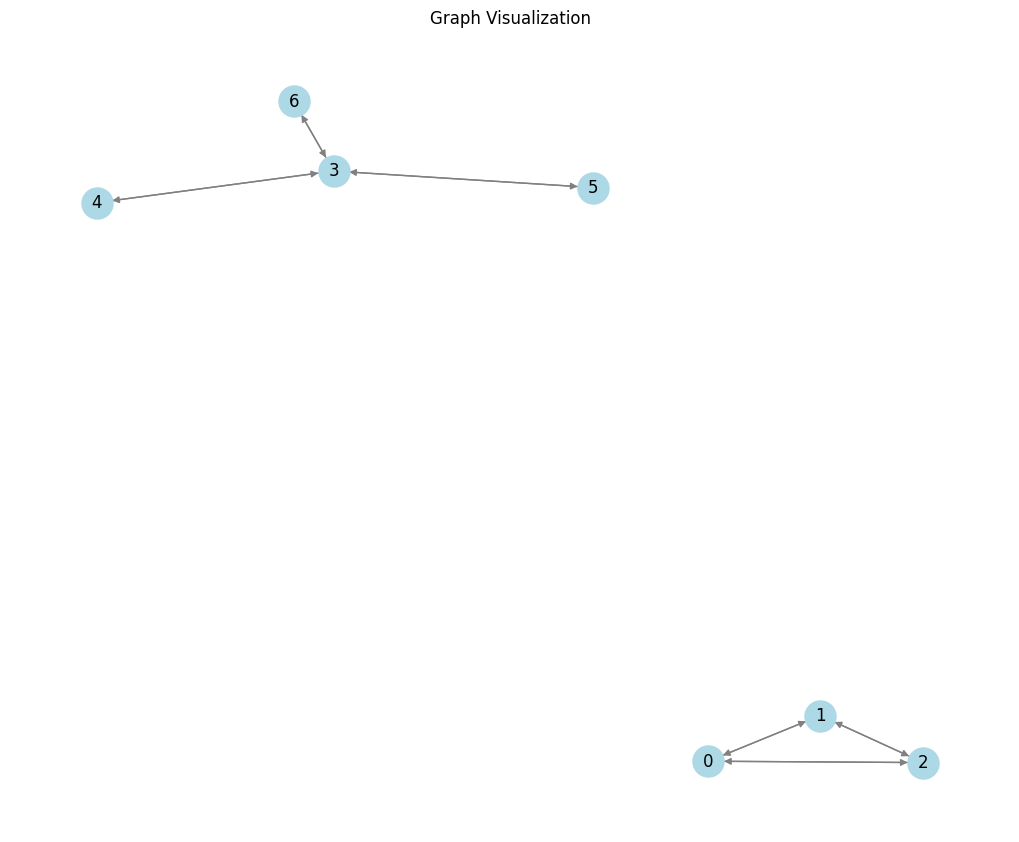

In [10]:
import torch
import torch_geometric

graph_A = torch_geometric.data.Data(
    x=torch.tensor([1.0, 2.0, 3.0]),
    edge_index=torch.tensor([[0, 0, 1, 1, 2, 2], [1, 2, 0, 2, 0, 1]], dtype=torch.long),
    y=torch.tensor([0, 0, 1]),
)
#plot_graph(graph_A)
graph_B = torch_geometric.data.Data(
    x=torch.tensor([-1.0, -2.0, -3.0, -4.0]),
    edge_index=torch.tensor([[0, 0, 0, 1, 2, 3], [1, 2, 3, 0, 0, 0]], dtype=torch.long),
    y=torch.tensor([0, 1, 0, 1]),
)
#plot_graph(graph_B)

def merge_graphs(graph_A, graph_B):
    x = torch.concat([graph_A.x, graph_B.x])
    y = torch.concat([graph_A.y, graph_B.y])
    edge_index = torch.concat([graph_A.edge_index, graph_B.edge_index + graph_A.x.shape[0]], dim=1)
    print(edge_index)
    return torch_geometric.data.Data(
        x=x,
        edge_index=edge_index,
        y=y,
    )

plot_graph(merge_graphs(graph_A, graph_B))

In [28]:
dataset = torch_geometric.datasets.PPI(root='./data')
print(len(dataset))

xs = torch.zeros(121)
for i in range(len(dataset)):
    xs = xs + dataset[i].y.mean(dim=0)
xs = xs / len(dataset)
print(xs)

20
tensor([0.6726, 0.2468, 0.2068, 0.2494, 0.1256, 0.1973, 0.2525, 0.3666, 0.1536,
        0.3482, 0.2218, 0.2566, 0.7133, 0.2012, 0.1971, 0.3848, 0.1014, 0.1405,
        0.2747, 0.4249, 0.1949, 0.6478, 0.2448, 0.3261, 0.1632, 0.6418, 0.6752,
        0.3432, 0.6979, 0.1898, 0.6994, 0.1453, 0.8913, 0.1739, 0.2310, 0.3307,
        0.2052, 0.2200, 0.4305, 0.2198, 0.1402, 0.2163, 0.2201, 0.2093, 0.1394,
        0.2954, 0.3873, 0.3944, 0.2473, 0.2475, 0.3702, 0.3136, 0.4559, 0.4358,
        0.2710, 0.2750, 0.1745, 0.1806, 0.1700, 0.2445, 0.4757, 0.1567, 0.2026,
        0.2198, 0.2142, 0.1249, 0.5014, 0.3358, 0.4771, 0.2866, 0.2473, 0.1632,
        0.1751, 0.3055, 0.2032, 0.1939, 0.3253, 0.1295, 0.2831, 0.2463, 0.2246,
        0.5150, 0.2924, 0.2091, 0.1658, 0.5836, 0.0898, 0.3019, 0.2920, 0.2099,
        0.1889, 0.2655, 0.3226, 0.1893, 0.2078, 0.3067, 0.1844, 0.4075, 0.4563,
        0.2723, 0.5136, 0.2759, 0.1700, 0.3176, 0.2000, 0.3120, 0.3050, 0.1894,
        0.4719, 0.3664, 0.3219, 0.197

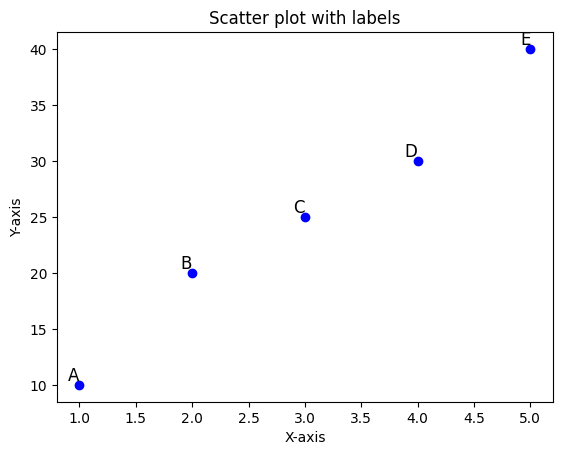

In [1]:
import matplotlib.pyplot as plt

# Data for points
x = [1, 2, 3, 4, 5]
y = [10, 20, 25, 30, 40]
labels = ['A', 'B', 'C', 'D', 'E']  # Labels for each point

# Create the scatter plot
plt.scatter(x, y, color='blue')

# Add labels for each point
for i, label in enumerate(labels):
    plt.text(x[i], y[i], label, fontsize=12, ha='right', va='bottom')

# Add axis labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter plot with labels')

# Show the plot
plt.show()


In [ ]:
# class MTA:

#     def __init__(self, target_model, graph, loss_fn, config, shadow_models=None):
#         self.target_model = target_model
#         self.graph = graph
#         self.loss_fn = loss_fn
#         self.config = config
#         if shadow_models is None:
#             self.shadow_models = []
#             self.train_shadow_models()
#         else:
#             self.shadow_models = shadow_models

#     def train_shadow_models(self):
#         config = self.config
#         criterion = Accuracy(task="multiclass", num_classes=self.graph.num_classes).to(config.device)
#         train_config = trainer.TrainConfig(
#             criterion=criterion,
#             device=config.device,
#             epochs=config.epochs,
#             early_stopping=config.early_stopping,
#             loss_fn=self.loss_fn,
#             lr=config.lr,
#             weight_decay=config.weight_decay,
#             optimizer=getattr(torch.optim, config.optimizer),
#         )
#         shadow_train_masks = utils.partition_training_sets(num_nodes=self.graph.num_nodes, num_models=config.num_shadow_models)
#         for shadow_train_mask in tqdm(shadow_train_masks, total=shadow_train_masks.shape[0], desc=f"Training {config.num_shadow_models} shadow models for MTA attack"):
#             shadow_dataset = datasetup.remasked_graph(self.graph, shadow_train_mask)
#             shadow_model = utils.fresh_model(
#                 model_type=config.model,
#                 num_features=shadow_dataset.num_features,
#                 hidden_dims=config.hidden_dim,
#                 num_classes=shadow_dataset.num_classes,
#                 dropout=config.dropout,
#             )
#             _ = trainer.train_gnn(
#                 model=shadow_model,
#                 dataset=shadow_dataset,
#                 config=train_config,
#                 disable_tqdm=True,
#                 inductive_split=config.inductive_split,
#             )
#             shadow_model.eval()
#             self.shadow_models.append(shadow_model)

#     def hinge(self, model, x, y):
#         with torch.inference_mode():
#             empty_edge_index = torch.tensor([[],[]], dtype=torch.long).to(self.config.device)
#             preds = model(x, empty_edge_index)
#             hinge = utils.hinge_loss(preds, y)
#         return hinge

#     def log_model_posterior(self, x, y):
#         hinge = self.hinge(self.target_model, x, y)
#         threshold = torch.stack([
#             self.hinge(shadow_model, x, y)
#             for shadow_model in self.shadow_models
#         ]).mean(dim=0)
#         return hinge - threshold

#     def run_attack(self, target_node_index):
#         preds = self.log_model_posterior(self.graph.x[target_node_index], self.graph.y[target_node_index])
#         return preds

In [ ]:
# class BMIA2:

#     def __init__(self, target_model, graph, loss_fn, config, shadow_models=None):
#         self.target_model = target_model
#         self.graph = graph
#         self.loss_fn = loss_fn
#         self.config = config
#         self.eps = 1e-7
#         if shadow_models is None:
#             self.shadow_models = []
#             self.train_shadow_models()
#         else:
#             self.shadow_models = shadow_models

#     def train_shadow_models(self):
#         config = self.config
#         criterion = Accuracy(task="multiclass", num_classes=self.graph.num_classes).to(config.device)
#         train_config = trainer.TrainConfig(
#             criterion=criterion,
#             device=config.device,
#             epochs=config.epochs,
#             early_stopping=config.early_stopping,
#             loss_fn=self.loss_fn,
#             lr=config.lr,
#             weight_decay=config.weight_decay,
#             optimizer=getattr(torch.optim, config.optimizer),
#         )
#         shadow_train_masks = utils.partition_training_sets(num_nodes=self.graph.num_nodes, num_models=config.num_shadow_models)
#         for shadow_train_mask in tqdm(shadow_train_masks, total=shadow_train_masks.shape[0], desc=f"Training {config.num_shadow_models} shadow models for LSET attack"):
#             shadow_dataset = datasetup.remasked_graph(self.graph, shadow_train_mask)
#             shadow_model = utils.fresh_model(
#                 model_type=config.model,
#                 num_features=shadow_dataset.num_features,
#                 hidden_dims=config.hidden_dim,
#                 num_classes=shadow_dataset.num_classes,
#                 dropout=config.dropout,
#             )
#             _ = trainer.train_gnn(
#                 model=shadow_model,
#                 dataset=shadow_dataset,
#                 config=train_config,
#                 disable_tqdm=True,
#                 inductive_split=config.inductive_split,
#             )
#             shadow_model.eval()
#             self.shadow_models.append(shadow_model)

#     def run_attack(self, target_node_index):
#         config = self.config
#         n_samples = len(self.shadow_models)
#         x = self.graph.x[target_node_index]
#         y = self.graph.y[target_node_index]
#         empty_edge_index = torch.tensor([[],[]], dtype=torch.long).to(config.device)
#         with torch.inference_mode():
#             preds = self.target_model(x, empty_edge_index)
#         row_idx = torch.arange(x.shape[0])
#         target_scores = F.softmax(preds, dim=1)[row_idx, y].logit(eps=self.eps)
#         sampled_preds = []
#         with torch.inference_mode():
#             for shadow_model in self.shadow_models:
#                 sampled_preds.append(F.softmax(shadow_model(x, empty_edge_index), dim=1))
#         sampled_scores = []
#         for i in range(n_samples):
#             logit = sampled_preds[i][row_idx, y].logit(eps=self.eps)
#             sampled_scores.append(logit)
#         sampled_scores = torch.stack(sampled_scores)
#         ds = target_scores - sampled_scores
#         d_mean = ds.mean(0)
#         d_std = ds.std(0)
#         t = n_samples ** -0.5 * d_mean / (d_std + self.eps)
#         preds = t_dist.cdf(t, n_samples - 1)
#         assert preds.shape == target_node_index.shape
#         return preds

In [10]:
import torch

a = torch.randperm(5)
a.sort().values

tensor([0, 1, 2, 3, 4])

In [7]:
import math
q = 0.938
u = 1 / (2 * q ** 3)
a = 3 * q ** 2 * u
b = math.exp(q) * u ** 2
b - 1
c = 2 * math.exp(q) * u
q ** 3, c

(0.8252936719999998, 3.0957059998441956)